In [1]:
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import GRU, Input, Dense, TimeDistributed, Activation, RepeatVector, Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy

In [14]:
import os

def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r", encoding ='utf=8') as f:
        data = f.read()

    return data.split('\n')


from keras.losses import sparse_categorical_crossentropy
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical


def _test_model(model, input_shape, output_sequence_length, french_vocab_size):
    if isinstance(model, Sequential):
        model = model.model

    assert model.input_shape == (None, *input_shape[1:]),'Wrong input shape. Found input shape {} using parameter input_shape={}'.format(model.input_shape, input_shape)

    assert model.output_shape == (None, output_sequence_length, french_vocab_size),'Wrong output shape. Found output shape {} using parameters output_sequence_length={} and french_vocab_size={}'.format(model.output_shape, output_sequence_length, french_vocab_size)

    assert len(model.loss_functions) > 0,'No loss function set.  Apply the `compile` function to the model.'

    assert sparse_categorical_crossentropy in model.loss_functions,'Not using `sparse_categorical_crossentropy` function for loss.'


def test_tokenize(tokenize):
    sentences = [
        'আমি এই উপন্যাস আগেও পড়েছি।',
        'টম খুব খোলামেলা মানুষ।',
        'তুমি কি কখনো হেলিকপ্টারে বসেছো?']
    tokenized_sentences, tokenizer = tokenize(sentences)
    assert tokenized_sentences == tokenizer.texts_to_sequences(sentences),\
        'Tokenizer returned and doesn\'t generate the same sentences as the tokenized sentences returned. '


def test_pad(pad):
    tokens = [
        [i for i in range(4)],
        [i for i in range(6)],
        [i for i in range(3)]]
    padded_tokens = pad(tokens)
    padding_id = padded_tokens[0][-1]
    true_padded_tokens = np.array([
        [i for i in range(4)] + [padding_id]*2,
        [i for i in range(6)],
        [i for i in range(3)] + [padding_id]*3])
    assert isinstance(padded_tokens, np.ndarray),\
        'Pad returned the wrong type.  Found {} type, expected numpy array type.'
    assert np.all(padded_tokens == true_padded_tokens), 'Pad returned the wrong results.'

    padded_tokens_using_length = pad(tokens, 9)
    assert np.all(padded_tokens_using_length == np.concatenate((true_padded_tokens, np.full((3, 3), padding_id)), axis=1)),\
        'Using length argument return incorrect results'


def test_simple_model(simple_model):
    input_shape = (80000, 17, 1)
    output_sequence_length = 17
    english_vocab_size = 12201
    french_vocab_size = 14157

    model = simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size)
    _test_model(model, input_shape, output_sequence_length, french_vocab_size)


def test_embed_model(embed_model):
    input_shape = (200000, 17)
    output_sequence_length = 17
    english_vocab_size = 12201
    french_vocab_size = 14157

    model = embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size)
    _test_model(model, input_shape, output_sequence_length, french_vocab_size)


def test_encdec_model(encdec_model):
    input_shape = (200000, 17, 1)
    output_sequence_length = 17
    english_vocab_size = 12201
    french_vocab_size = 14157

    model = encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size)
    _test_model(model, input_shape, output_sequence_length, french_vocab_size)


def test_bd_model(bd_model):
    input_shape = (200000, 17, 1)
    output_sequence_length = 17
    english_vocab_size = 12201
    french_vocab_size = 14157

    model = bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size)
    _test_model(model, input_shape, output_sequence_length, french_vocab_size)


def test_model_final(model_final):
    input_shape = (200000, 17)
    output_sequence_length = 17
    english_vocab_size = 12201
    french_vocab_size = 14157

    model = model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size)
    _test_model(model, input_shape, output_sequence_length, french_vocab_size)

In [5]:
english_sentences = load_data('/content/drive/My Drive/NLP_csv/80kban.txt')
french_sentences = load_data('/content/drive/My Drive/NLP_csv/80kger.txt')
print('Dataset Loaded')

Dataset Loaded


In [ ]:
for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_fr Line {}:  {}'.format(sample_i + 1, french_sentences[sample_i]))

In [7]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
french_words_counter = collections.Counter([word for sentence in french_sentences for word in sentence.split()])
print('{} English words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(english_words_counter)))
print('10 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} French words.'.format(len([word for sentence in french_sentences for word in sentence.split()])))
print('{} unique French words.'.format(len(french_words_counter)))
print('10 Most common words in the French dataset:')
print('"' + '" "'.join(list(zip(*french_words_counter.most_common(10)))[0]) + '"')

335708 English words.
14101 unique English words.
10 Most common words in the English dataset:
"আমি" "টম" "এটা" "কি" "তুমি" "আমার" "না।" "তোমার" "সে" "একটা"

356660 French words.
23231 unique French words.
10 Most common words in the French dataset:
"Tom" "Ich" "ist" "Sie" "nicht" "das" "du" "Das" "hat" "Er"


In [8]:
def tokenize(x):
    x_tk = Tokenizer(char_level = False)
    x_tk.fit_on_texts(x)
    return x_tk.texts_to_sequences(x), x_tk
text_sentences = [
    'টম হয়তো ফরাসি ভাষায় কথা বলতে পারবে না।',
    'টম খুব খোলামেলা মানুষ।',
    'তুমি কি কখনো হেলিকপ্টারে বসেছো?']
text_tokenized, text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)
print()
for sample_i, (sent, token_sent) in enumerate(zip(text_sentences, text_tokenized)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(sent))
    print('  Output: {}'.format(token_sent))

{'টম': 1, 'হয়তো': 2, 'ফরাসি': 3, 'ভাষায়': 4, 'কথা': 5, 'বলতে': 6, 'পারবে': 7, 'না।': 8, 'খুব': 9, 'খোলামেলা': 10, 'মানুষ।': 11, 'তুমি': 12, 'কি': 13, 'কখনো': 14, 'হেলিকপ্টারে': 15, 'বসেছো': 16}

Sequence 1 in x
  Input:  টম হয়তো ফরাসি ভাষায় কথা বলতে পারবে না।
  Output: [1, 2, 3, 4, 5, 6, 7, 8]
Sequence 2 in x
  Input:  টম খুব খোলামেলা মানুষ।
  Output: [1, 9, 10, 11]
Sequence 3 in x
  Input:  তুমি কি কখনো হেলিকপ্টারে বসেছো?
  Output: [12, 13, 14, 15, 16]


In [15]:
# import project_tests as tests
def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    return pad_sequences(x, maxlen = length, padding = 'post')
test_pad(pad)
# Pad Tokenized output
test_pad = pad(text_tokenized)
for sample_i, (token_sent, pad_sent) in enumerate(zip(text_tokenized, test_pad)):
    print('Sequence {} in x'.format(sample_i + 1))
    print('  Input:  {}'.format(np.array(token_sent)))
    print('  Output: {}'.format(pad_sent))

Sequence 1 in x
  Input:  [1 2 3 4 5 6 7 8]
  Output: [1 2 3 4 5 6 7 8]
Sequence 2 in x
  Input:  [ 1  9 10 11]
  Output: [ 1  9 10 11  0  0  0  0]
Sequence 3 in x
  Input:  [12 13 14 15 16]
  Output: [12 13 14 15 16  0  0  0]


In [16]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)
    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)
    # Keras's sparse_categorical_crossentropy function requires the labels to be in 3 dimensions
    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)
    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer = preprocess(english_sentences, french_sentences)    
max_english_sequence_length = preproc_english_sentences.shape[1]
max_french_sequence_length = preproc_french_sentences.shape[1]
english_vocab_size = len(english_tokenizer.word_index)
french_vocab_size = len(french_tokenizer.word_index)
print('Data Preprocessed')
print("Max English sentence length:", max_english_sequence_length)
print("Max French sentence length:", max_french_sequence_length)
print("English vocabulary size:", english_vocab_size)
print("French vocabulary size:", french_vocab_size)

Data Preprocessed
Max English sentence length: 17
Max French sentence length: 17
English vocabulary size: 12201
French vocabulary size: 14157


In [17]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'
    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
print('`logits_to_text` function loaded.')

`logits_to_text` function loaded.


In [19]:
def simple_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-2
    input_seq = Input(input_shape[1:])
    rnn = GRU(128, return_sequences = True)(input_seq)
    logits = TimeDistributed(Dense(french_vocab_size))(rnn)
    model = Model(input_seq, Activation('softmax')(logits))
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
# test_simple_model(simple_model)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
# Train the neural network
simple_rnn_model = simple_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)
history=simple_rnn_model.fit(tmp_x, preproc_french_sentences, batch_size=100, epochs=20, validation_split=0.2)
# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/20
640/640 [==============================] - 530s 826ms/step - loss: 2.0505 - accuracy: 0.7584 - val_loss: 1.9407 - val_accuracy: 0.7332
Epoch 2/20
640/640 [==============================] - 539s 843ms/step - loss: 1.4218 - accuracy: 0.7899 - val_loss: 1.9135 - val_accuracy: 0.7356
Epoch 3/20
640/640 [==============================] - 541s 846ms/step - loss: 1.3401 - accuracy: 0.7945 - val_loss: 1.9068 - val_accuracy: 0.7398
Epoch 4/20
640/640 [==============================] - 542s 847ms/step - loss: 1.2972 - accuracy: 0.7960 - val_loss: 1.9145 - val_accuracy: 0.7397
Epoch 5/20
640/640 [==============================] - 540s 844ms/step - loss: 1.2632 - accuracy: 0.7975 - val_loss: 1.9222 - val_accuracy: 0.7414
Epoch 6/20
640/640 [==============================] - 535s 836ms/step - loss: 1.2357 - accuracy: 0.7979 - val_loss: 1.9200 - val_accuracy: 0.7410
Epoch 7/20
640/640 [==============================] - 539s 842ms/step - loss: 1.2141 - accuracy: 0.7994 - val_loss: 1.9286 -

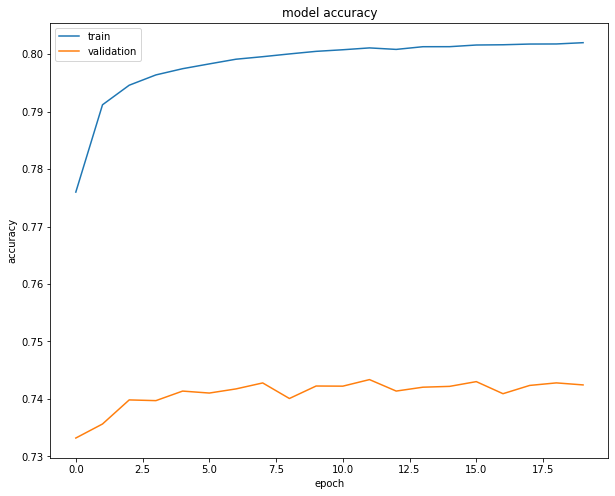

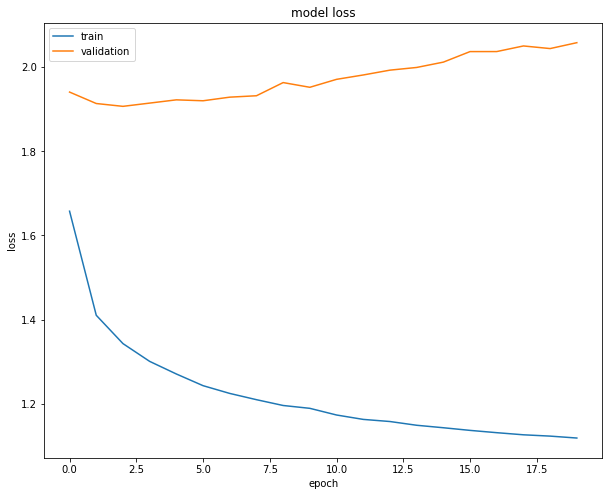

In [25]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_Accuracy.png',dpi=600)

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_loss.png', dpi=600)

plt.show()

In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'
    sentence = ''
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    debug1 = sentence
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    debug2 = sentence
    sentences = np.array([sentence[0], x[0]])
    debug3 = sentences
    predictions = simple_rnn_model.predict(sentences, len(sentences))
    debug4 = predictions
    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('ওহে')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[1209]]))
    a = []
    for i in range(0,len(french_sentences)):
        debug5 = " ".join([y_id_to_word[np.max(x)] for x in y[i]])
        if i  == 1:
            debug4 = debug5
        a.append(debug5)        
    from pandas import DataFrame
    df = DataFrame(a,columns=["predicted string"])
    df["predicted string"]= df["predicted string"].str.replace("<PAD>", "", case = False) 
    df["actual language"] = french_sentences

    
    return debug1, debug2, debug3, debug4, debug5, a, df
debug1, debug2, debug3, debug4, debug5,  a, df = final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)
#df.to_csv("jekhane khushi save kore ne sagol.csv")

Sample 1:
brauchst tages ich <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
ওহে
Sample 2:
die <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
prüfen sie das nach <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
df_test = df

In [ ]:
remove_characters = ["?", ".","!",","]

for c in remove_characters:
    df_test["actual language"] =  df_test["actual language"].str.replace(c,"")

df_test["actual language"] = df_test["actual language"] .str.lower()

In [ ]:
df_test

,predicted string,actual language
0,geh,geh
1,hallo,hallo
2,grüß gott,grüß gott
3,lauf,lauf
4,lauf,lauf
...,...,...
79995,ich habe nicht so viel mut wie ihr,ich habe nicht so viel mut wie ihr
79996,das habe ich nicht vor,das habe ich nicht vor
79997,ich weiss toms nummer nicht,ich weiss toms nummer nicht
79998,ich weiß nicht wie ich das gemacht habe,ich weiß nicht wie ich das gemacht habe


In [ ]:
col_1 = df['predicted string'].tolist()
col_2 = df["actual language"].tolist()


from nltk.translate.bleu_score import corpus_bleu
#reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
#candidate = ['this', 'is', 'a', 'test']
score1 = corpus_bleu(col_2, col_1, weights=(1, 0, 0, 0))
score2 = corpus_bleu(col_2, col_1, weights=(0.5, 0.5, 0, 0))
score3 = corpus_bleu(col_2, col_1, weights=(0.33, 0.33, 0.33, 0))
score4 = corpus_bleu(col_2, col_1, weights=(0.25, 0.25, 0.25, 0.25))
score21 = corpus_bleu(col_2, col_1, weights=(0.5, 0.5, 0, 0))
score31 = corpus_bleu(col_2, col_1, weights=(0.33, 0.33, 0.33, 0))
score41 = corpus_bleu(col_2, col_1, weights=(0.25, 0.25, 0.25, 0.25))
print(score1)
print(score2)
print(score3)
print(score4)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3561822299031535
0.5968100450756116
0.7112984167321372
0.7725348180345087


In [ ]:
score11 = corpus_bleu(col_2, col_1, weights=(1, 0, 0, 0))
score21 = corpus_bleu(col_2, col_1, weights=(0, 1, 0, 0))
score31 = corpus_bleu(col_2, col_1, weights=(0, 0, 1, 0))
score41 = corpus_bleu(col_2, col_1, weights=(0, 0, 0, 1))
print(score11)
print(score21)
print(score31)
print(score41)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3561822299031535
1.0
1.0
1.0


In [ ]:
from keras.models import Sequential
def embed_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
    learning_rate = 1e-2
    rnn = GRU(128, return_sequences=True, activation="softmax")
    
    embedding = Embedding(french_vocab_size, 128, input_length=input_shape[1]) 
    logits = TimeDistributed(Dense(french_vocab_size, activation="softmax"))
    
    model = Sequential()
    #em can only be used in first layer --> Keras Documentation
    model.add(embedding)
    model.add(rnn)
    model.add(logits)
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model
# tests.test_embed_model(embed_model)
tmp_x = pad(preproc_english_sentences, max_french_sequence_length)
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2]))
embeded_model = embed_model(
    tmp_x.shape,
    max_french_sequence_length,
    english_vocab_size+1,
    french_vocab_size+1)
embeded_model.fit(tmp_x, preproc_french_sentences, batch_size=100, epochs=20, validation_split=0.2)
print(logits_to_text(embeded_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/20
640/640 [==============================] - 673s 1s/step - loss: 2.8329 - accuracy: 0.7532 - val_loss: 2.1275 - val_accuracy: 0.7088
Epoch 2/20
640/640 [==============================] - 669s 1s/step - loss: 1.6381 - accuracy: 0.7664 - val_loss: 2.0239 - val_accuracy: 0.7175
Epoch 3/20
640/640 [==============================] - 669s 1s/step - loss: 1.5272 - accuracy: 0.7781 - val_loss: 1.9628 - val_accuracy: 0.7201
Epoch 4/20
640/640 [==============================] - 669s 1s/step - loss: 1.4454 - accuracy: 0.7893 - val_loss: 1.9137 - val_accuracy: 0.7342
Epoch 5/20
640/640 [==============================] - 669s 1s/step - loss: 1.3865 - accuracy: 0.7933 - val_loss: 1.8952 - val_accuracy: 0.7350
Epoch 6/20
640/640 [==============================] - 672s 1s/step - loss: 1.3462 - accuracy: 0.7961 - val_loss: 1.8693 - val_accuracy: 0.7398
Epoch 7/20
640/640 [==============================] - 673s 1s/step - loss: 1.3038 - accuracy: 0.7998 - val_loss: 1.8439 - val_accuracy: 0.7421

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_Accuracy.png',dpi=600)

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_loss.png', dpi=600)

plt.show()

In [ ]:
def bd_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
   
    learning_rate = 1e-2
    model = Sequential()
    model.add(Bidirectional(GRU(128, return_sequences = True, dropout = 0.1), 
                           input_shape = input_shape[1:]))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    return model
# tests.test_bd_model(bd_model)
tmp_x = pad(preproc_english_sentences, preproc_french_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_french_sentences.shape[-2], 1))
bidi_model = bd_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)
bidi_model.fit(tmp_x, preproc_french_sentences, batch_size=100, epochs=20, validation_split=0.2)
# Print prediction(s)
print(logits_to_text(bidi_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/20
640/640 [==============================] - 874s 1s/step - loss: 1.7357 - accuracy: 0.7789 - val_loss: 1.9740 - val_accuracy: 0.7345
Epoch 2/20
640/640 [==============================] - 875s 1s/step - loss: 1.4460 - accuracy: 0.7937 - val_loss: 1.9187 - val_accuracy: 0.7407
Epoch 3/20
640/640 [==============================] - 883s 1s/step - loss: 1.3597 - accuracy: 0.7980 - val_loss: 1.8877 - val_accuracy: 0.7396
Epoch 4/20
640/640 [==============================] - 879s 1s/step - loss: 1.3233 - accuracy: 0.7994 - val_loss: 1.8711 - val_accuracy: 0.7424
Epoch 5/20
640/640 [==============================] - 879s 1s/step - loss: 1.2838 - accuracy: 0.8018 - val_loss: 1.8614 - val_accuracy: 0.7418
Epoch 6/20
640/640 [==============================] - 874s 1s/step - loss: 1.2615 - accuracy: 0.8023 - val_loss: 1.8649 - val_accuracy: 0.7402
Epoch 7/20
640/640 [==============================] - 882s 1s/step - loss: 1.2389 - accuracy: 0.8034 - val_loss: 1.8597 - val_accuracy: 0.7439

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_Accuracy.png',dpi=600)

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_loss.png', dpi=600)

plt.show()

In [ ]:
def encdec_model(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
  
    learning_rate = 1e-2
    model = Sequential()
    model.add(GRU(128, input_shape = input_shape[1:], return_sequences = False))
    model.add(RepeatVector(output_sequence_length))
    model.add(GRU(128, return_sequences = True))
    model.add(TimeDistributed(Dense(french_vocab_size, activation = 'softmax')))
    
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    return model
# tests.test_encdec_model(encdec_model)
tmp_x = pad(preproc_english_sentences)
tmp_x = tmp_x.reshape((-1, preproc_english_sentences.shape[1], 1))
encodeco_model = encdec_model(
    tmp_x.shape,
    preproc_french_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(french_tokenizer.word_index)+1)
encodeco_model.fit(tmp_x, preproc_french_sentences, batch_size=100, epochs=20, validation_split=0.2)
print(logits_to_text(encodeco_model.predict(tmp_x[:1])[0], french_tokenizer))

Epoch 1/20
640/640 [==============================] - 668s 1s/step - loss: 2.0448 - accuracy: 0.7632 - val_loss: 2.4684 - val_accuracy: 0.7125
Epoch 2/20
640/640 [==============================] - 668s 1s/step - loss: 1.8733 - accuracy: 0.7741 - val_loss: 2.3670 - val_accuracy: 0.7283
Epoch 3/20
640/640 [==============================] - 667s 1s/step - loss: 1.7759 - accuracy: 0.7874 - val_loss: 2.2791 - val_accuracy: 0.7342
Epoch 4/20
640/640 [==============================] - 663s 1s/step - loss: 1.5381 - accuracy: 0.7918 - val_loss: 1.9635 - val_accuracy: 0.7365
Epoch 5/20
640/640 [==============================] - 669s 1s/step - loss: 1.4253 - accuracy: 0.7950 - val_loss: 1.9116 - val_accuracy: 0.7397
Epoch 6/20
640/640 [==============================] - 668s 1s/step - loss: 1.3890 - accuracy: 0.7971 - val_loss: 1.9038 - val_accuracy: 0.7407
Epoch 7/20
640/640 [==============================] - 672s 1s/step - loss: 1.3674 - accuracy: 0.7983 - val_loss: 1.8852 - val_accuracy: 0.7428

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_Accuracy.png',dpi=600)

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_loss.png', dpi=600)

plt.show()

In [26]:
def model_final(input_shape, output_sequence_length, english_vocab_size, french_vocab_size):
  
    model = Sequential()
    model.add(Embedding(input_dim=english_vocab_size,output_dim=128,input_length=input_shape[1]))
    model.add(Bidirectional(GRU(128,return_sequences=False)))
    model.add(RepeatVector(output_sequence_length))
    model.add(Bidirectional(GRU(128,return_sequences=True)))
    model.add(TimeDistributed(Dense(french_vocab_size,activation='softmax')))
    learning_rate = 1e-2
    
    model.compile(loss = sparse_categorical_crossentropy, 
                 optimizer = Adam(learning_rate), 
                 metrics = ['accuracy'])
    
    return model
# tests.test_model_final(model_final)
print('Final Model Loaded')

Final Model Loaded


In [27]:
tmp_X = pad(preproc_english_sentences)
model = model_final(tmp_X.shape,preproc_french_sentences.shape[1],len(english_tokenizer.word_index)+1,len(french_tokenizer.word_index)+1)
history=model.fit(tmp_X, preproc_french_sentences, batch_size = 100, epochs = 20, validation_split = 0.2)
model.save('Finalmodel.model')

640/640 [==============================] - 1085s 2s/step - loss: 2.2606 - accuracy: 0.7590 - val_loss: 2.3652 - val_accuracy: 0.7419


INFO:tensorflow:Assets written to: Finalmodel.model/assets


INFO:tensorflow:Assets written to: Finalmodel.model/assets


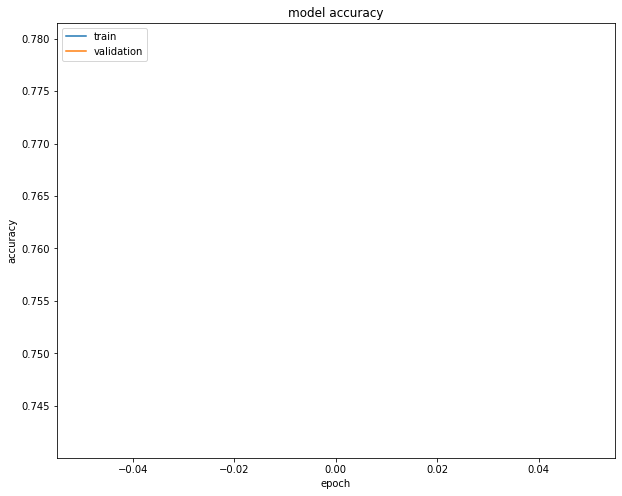

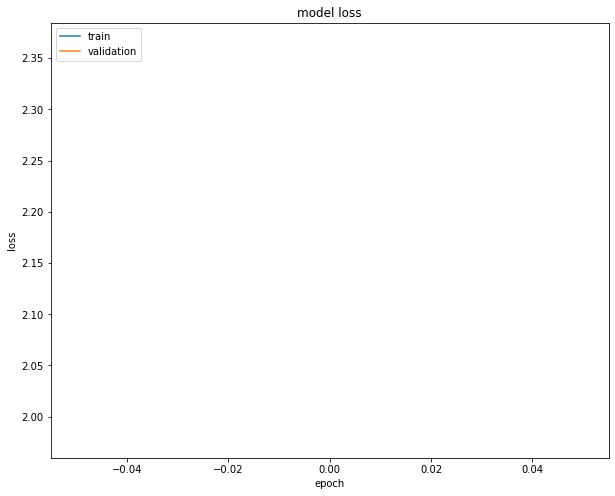

In [29]:
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_Accuracy.png',dpi=600)

plt.show()


plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.savefig('model_loss.png', dpi=600)

plt.show()

In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'
    sentence = ''
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    debug1 = sentence
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    debug2 = sentence
    sentences = np.array([sentence[0], x[0]])
    debug3 = sentences
    predictions = model.predict(sentences, len(sentences))
    debug4 = predictions
    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('ওহে')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[1209]]))
    a = []
    for i in range(0,len(french_sentences)):
        debug5 = " ".join([y_id_to_word[np.max(x)] for x in y[i]])
        if i  == 1:
            debug4 = debug5
        a.append(debug5)        
    from pandas import DataFrame
    df = DataFrame(a,columns=["predicted string"])
    df["predicted string"]= df["predicted string"].str.replace("<PAD>", "", case = False) 
    df["actual language"] = french_sentences

    
    return debug1, debug2, debug3, debug4, debug5, a, df
debug1, debug2, debug3, debug4, debug5,  a, df = final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)
#df.to_csv("jekhane khushi save kore ne sagol.csv")

Sample 1:
sie ist <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
ওহে
Sample 2:
sie ist <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
prüfen sie das nach <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [ ]:
df_test = df

In [ ]:
remove_characters = ["?", ".","!",","]

for c in remove_characters:
    df_test["actual language"] =  df_test["actual language"].str.replace(c,"")

df_test["actual language"] = df_test["actual language"] .str.lower()

In [ ]:
df_test

,predicted string,actual language
0,geh,geh
1,hallo,hallo
2,grüß gott,grüß gott
3,lauf,lauf
4,lauf,lauf
...,...,...
79995,ich habe nicht so viel mut wie ihr,ich habe nicht so viel mut wie ihr
79996,das habe ich nicht vor,das habe ich nicht vor
79997,ich weiss toms nummer nicht,ich weiss toms nummer nicht
79998,ich weiß nicht wie ich das gemacht habe,ich weiß nicht wie ich das gemacht habe


In [ ]:
col_1 = df['predicted string'].tolist()
col_2 = df["actual language"].tolist()


from nltk.translate.bleu_score import corpus_bleu
#reference = [['this', 'is', 'a', 'test'], ['this', 'is' 'test']]
#candidate = ['this', 'is', 'a', 'test']
score1 = corpus_bleu(col_2, col_1, weights=(1, 0, 0, 0))
score2 = corpus_bleu(col_2, col_1, weights=(0.5, 0.5, 0, 0))
score3 = corpus_bleu(col_2, col_1, weights=(0.33, 0.33, 0.33, 0))
score4 = corpus_bleu(col_2, col_1, weights=(0.25, 0.25, 0.25, 0.25))
score21 = corpus_bleu(col_2, col_1, weights=(0.5, 0.5, 0, 0))
score31 = corpus_bleu(col_2, col_1, weights=(0.33, 0.33, 0.33, 0))
score41 = corpus_bleu(col_2, col_1, weights=(0.25, 0.25, 0.25, 0.25))
print(score1)
print(score2)
print(score3)
print(score4)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3561822299031535
0.5968100450756116
0.7112984167321372
0.7725348180345087


In [ ]:
score11 = corpus_bleu(col_2, col_1, weights=(1, 0, 0, 0))
score21 = corpus_bleu(col_2, col_1, weights=(0, 1, 0, 0))
score31 = corpus_bleu(col_2, col_1, weights=(0, 0, 1, 0))
score41 = corpus_bleu(col_2, col_1, weights=(0, 0, 0, 1))
print(score11)
print(score21)
print(score31)
print(score41)

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.3561822299031535
1.0
1.0
1.0


In [ ]:
def final_predictions(x, y, x_tk, y_tk):
    y_id_to_word = {value: key for key, value in y_tk.word_index.items()}
    y_id_to_word[0] = '<PAD>'
    sentence = ''
    sentence = [x_tk.word_index[word] for word in sentence.split()]
    sentence = pad_sequences([sentence], maxlen=x.shape[-1], padding='post')
    sentences = np.array([sentence[0], x[0]])
    predictions = model.predict(sentences, len(sentences))
    print('Sample 1:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[0]]))
    print('ওহে')
    print('Sample 2:')
    print(' '.join([y_id_to_word[np.argmax(x)] for x in predictions[1]]))
    print(' '.join([y_id_to_word[np.max(x)] for x in y[40764]]))
final_predictions(preproc_english_sentences, preproc_french_sentences, english_tokenizer, french_tokenizer)

Sample 1:
sie ist <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
ওহে
Sample 2:
sie ist <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
es ist schön mit dir zusammen zu sein <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>
